# Lab - RNNs, LSTMs and GRUs

## Integrantes
- Jose Asitimbay
- Brayan Lechon

# Activities

Repeat the sentiment analysis exercise from Lab 2. For this one you will consider the following models:

- RNN
- LSTM
- GRU

Compare the results with each other and the Naive Bayes model obtained in Lab 2. The group with the best weighted F1 score gets 3 extra points to the final grade, the second best get 2 points, and the third gets 1 point. 

To simplify, consider only 3 categories: negative, neutral and positive.

In [13]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, DataLoader,random_split
import torch.optim as optim


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm


import nltk
# Descargar el tokenizador de NLTK si no está ya descargado
# nltk.download('punkt')
# nltk.download('punkt_base')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

adaptamos el codigo para que funcione con cuda

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(f"GPU encontrada: {torch.cuda.get_device_name(0)}")

GPU encontrada: NVIDIA GeForce RTX 4060 Laptop GPU


## Dataset

In [15]:
df = pd.read_csv('./data/train.tsv.zip', sep='\t')
df_criticas = df[['Phrase', 'Sentiment']].copy(deep=True)
print(df_criticas.shape)
df_criticas.head()


(156060, 2)


,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


agrupamos los sentimientos en 3 categorias

In [16]:
def sentiment_label(sentiment):
    if sentiment <= 1:
        return 0
    elif sentiment == 2:
        return 1
    else:
        return 2

df_criticas['Sentiment'] = df['Sentiment'].apply(sentiment_label)
df_criticas['Sentiment_label'] = df_criticas['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

<Axes: title={'center': 'len'}, xlabel='Sentiment_label'>

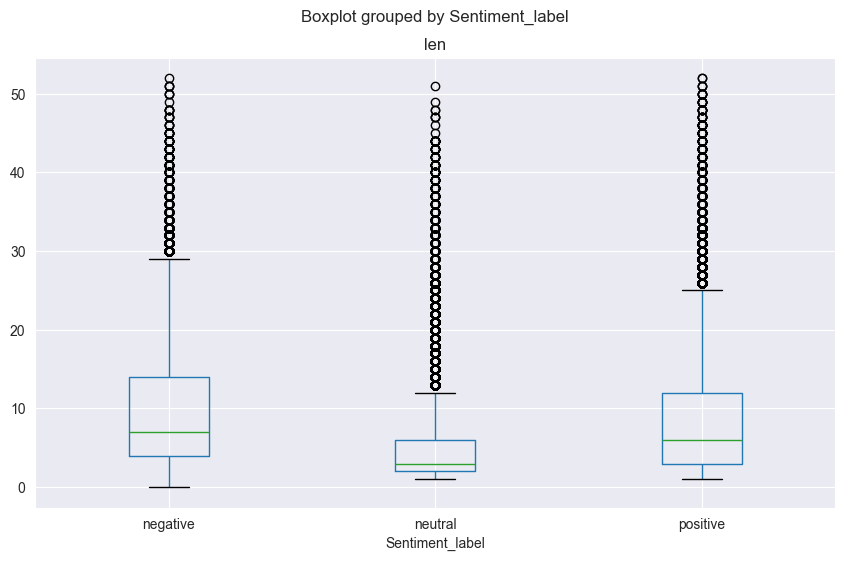

In [17]:
# boxplot of the length of the phrases by sentiment
df_criticas['Phrase'] = df_criticas['Phrase'].astype(str)
df_criticas['len'] = df_criticas['Phrase'].apply(lambda x: len(x.split()))
df_criticas.boxplot(column='len', by='Sentiment_label', figsize=(10, 6))


### Preprocesamiento de texto

tokens del texto con una limpeza eliminando signos de puntuación y convirtiendo el texto a minúsculas

In [18]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)    
    return tokenizer(text)

def tokenizer(text):
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    return tokens

df_criticas['Text'] = df_criticas['Phrase'].apply(clean_text)

# filter phrases with less than 2 words

filtramos a las frases con menos de 2 palabras

In [19]:
df_criticas['n_words'] = df_criticas['Text'].apply(len)
df_criticas = df_criticas[df_criticas['n_words'] > 2]

df_criticas.shape

(82196, 6)

con el filtrado realizado tendríamos respuestas que aportan un valor significativo

In [20]:
df_criticas.head(20)

,Phrase,Sentiment,Sentiment_label,len,Text,n_words
0,A series of escapades demonstrating the adage ...,0,negative,37,"[series, escapades, demonstrating, adage, good...",15
1,A series of escapades demonstrating the adage ...,1,neutral,14,"[series, escapades, demonstrating, adage, good...",6
5,of escapades demonstrating the adage that what...,1,neutral,12,"[escapades, demonstrating, adage, good, goose]",5
7,escapades demonstrating the adage that what is...,1,neutral,11,"[escapades, demonstrating, adage, good, goose]",5
9,demonstrating the adage that what is good for ...,1,neutral,10,"[demonstrating, adage, good, goose]",4
27,"is also good for the gander , some of which oc...",1,neutral,23,"[also, good, gander, occasionally, amuses, non...",9
28,"is also good for the gander , some of which oc...",1,neutral,22,"[also, good, gander, occasionally, amuses, non...",9
31,"good for the gander , some of which occasional...",1,neutral,20,"[good, gander, occasionally, amuses, none, amo...",8
32,"for the gander , some of which occasionally am...",1,neutral,19,"[gander, occasionally, amuses, none, amounts, ...",7
33,"the gander , some of which occasionally amuses...",0,negative,18,"[gander, occasionally, amuses, none, amounts, ...",7


# Dataset

In [21]:
# Cargar y preprocesar datos
  # Asegúrate de usar el nombre correcto del archivo
df_criticas['Sentiment'] = df_criticas['Sentiment'].astype(int)

# Función para tokenizar
def tokenize(text, clean=False):
    text = re.sub(r'[^\w\s]','',text)  
    tokens = word_tokenize(text.lower())
    # quitar stopwords
    if clean:
        tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Construir vocabulario
def build_vocab(texts, min_freq=2):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenize(text))
    
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

vocab = build_vocab(df_criticas['Phrase'])


In [22]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, sentiments, vocab, max_length=30):
        self.reviews = reviews
        self.sentiments = sentiments
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        sentiment = self.sentiments[idx]
        
        # Tokenizar y convertir a índices
        tokens = tokenize(review,clean=True)
        
        encoded = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        
        # Padding
        if len(encoded) < self.max_length:
            encoded = encoded + [self.vocab['<pad>']] * (self.max_length - len(encoded))
        else:
            encoded = encoded[:self.max_length]
        
        return torch.tensor(encoded), torch.tensor(sentiment)

In [23]:
dataset = ReviewsDataset(df_criticas['Phrase'].tolist(), df_criticas['Sentiment'].tolist(), vocab)

In [24]:
# sanity check
for i in range(5):
    print(dataset[i])

(tensor([ 3,  5,  6,  8, 12, 14, 15, 12, 16, 19, 20, 22, 23, 25, 26,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(0))
(tensor([ 3,  5,  6,  8, 12, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(1))
(tensor([ 5,  6,  8, 12, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(1))
(tensor([ 5,  6,  8, 12, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(1))
(tensor([ 6,  8, 12, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(1))


In [25]:
# Dividir datos
train_df, test_df = train_test_split(df_criticas,stratify=df_criticas['Sentiment'], test_size=0.2, random_state=13)

# Crear datasets
train_dataset = ReviewsDataset(train_df['Phrase'].tolist(), train_df['Sentiment'].tolist(), vocab)
test_dataset = ReviewsDataset(test_df['Phrase'].tolist(), test_df['Sentiment'].tolist(), vocab)

## RNN

In [26]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

configuracion de parametros

In [27]:

# Configuración del modelo
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 1
DROPOUT = 0.2
LR = 0.0001

EPOCHS = 60

# Inicializar modelo con RNN
model_rnn = SentimentRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# Configurar optimizador y función de pérdida
optimizer = optim.Adam(model_rnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn.to(device)


SentimentRNN(
  (embedding): Embedding(15941, 300, padding_idx=0)
  (rnn): RNN(300, 256, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

entrenamiento del modelo

100%|█████████▉| 61675/61680 [12:31<00:00, 82.30it/s]

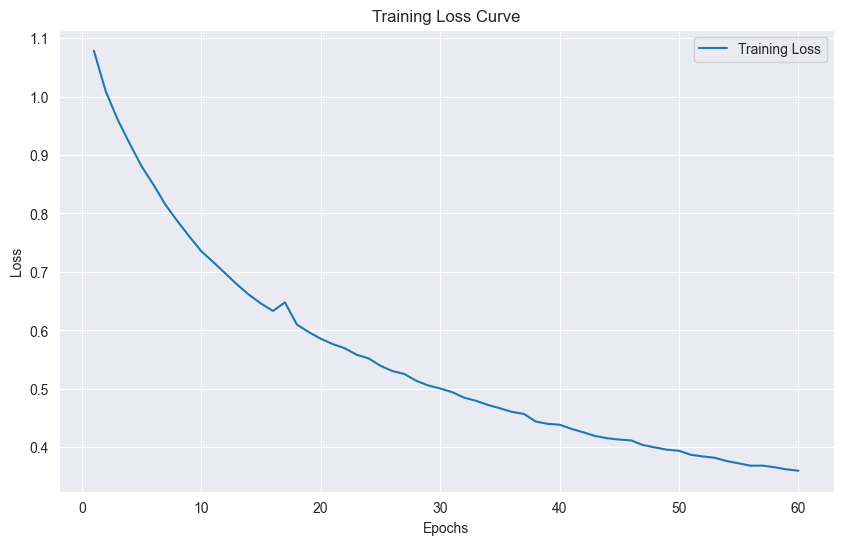

In [28]:
train_losses = []

# Barra de progreso para las épocas
progress_bar = tqdm(range(EPOCHS * len(train_loader)))

# Entrenamiento
for epoch in range(EPOCHS):
    model_rnn.train()
    epoch_loss = 0

    for batch in train_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_rnn(text)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.update()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

# Visualizar la curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [29]:
def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # Para almacenar las probabilidades
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting"):
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            output = model(text)
            probs = torch.softmax(output, dim=1)
            _, preds = torch.max(probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def evaluate_model(model, test_dataset, device, batch_size=64):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    y_pred, y_true, y_probs = predict(model, test_loader, device)
    
    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Mostrar el informe de clasificación
    print(classification_report(y_true, y_pred))
    
    # Calcular y mostrar la precisión global
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    return y_pred, y_true, y_probs


Predicting: 100%|██████████| 257/257 [00:02<00:00, 108.69it/s]


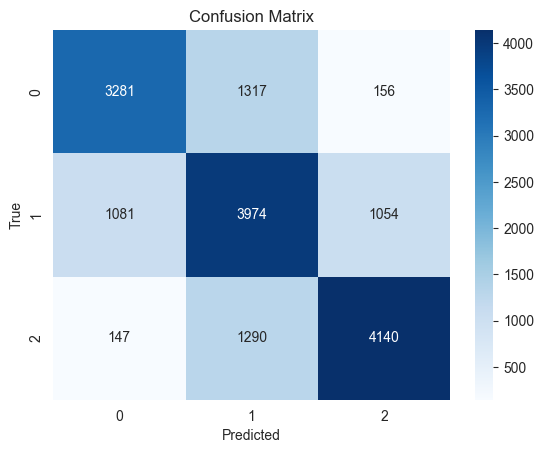

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4754
           1       0.60      0.65      0.63      6109
           2       0.77      0.74      0.76      5577

    accuracy                           0.69     16440
   macro avg       0.70      0.69      0.70     16440
weighted avg       0.70      0.69      0.69     16440

Overall Accuracy: 0.6931


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_pred, y_true, y_probs = evaluate_model(model_rnn, test_dataset, device)

## LSTM

In [32]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, bidirectional=True, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))        
        output, (hidden, cell) = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        dense = F.relu(self.fc(hidden))
        return self.output(dense)


100%|██████████| 61680/61680 [12:34<00:00, 81.78it/s]

100%|█████████▉| 61679/61680 [33:02<00:00, 18.87it/s]

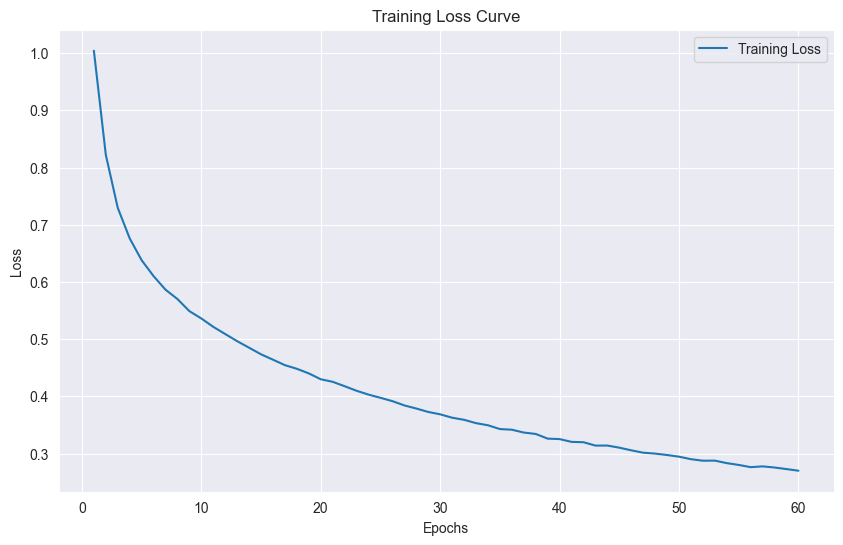

In [33]:
# Configuración del modelo
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
DROPOUT = 0.2
EPOCHS = 60
LR = 0.0001
# Inicializar modelo
model_lstm = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# Configurar optimizador y función de pérdida
optimizer = optim.Adam(model_lstm.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Configurar entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm.to(device)

# Listas para almacenar las pérdidas
train_losses = []
# Barra de progreso para las épocas
progress_bar = tqdm(range(EPOCHS * len(train_loader)))
# Entrenamiento

for epoch in range(EPOCHS):
    model_lstm.train()
    epoch_loss = 0
    
    for batch in train_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model_lstm(text)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    

        progress_bar.update()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

# Visualizar la curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

Predicting: 100%|██████████| 257/257 [00:07<00:00, 36.46it/s]


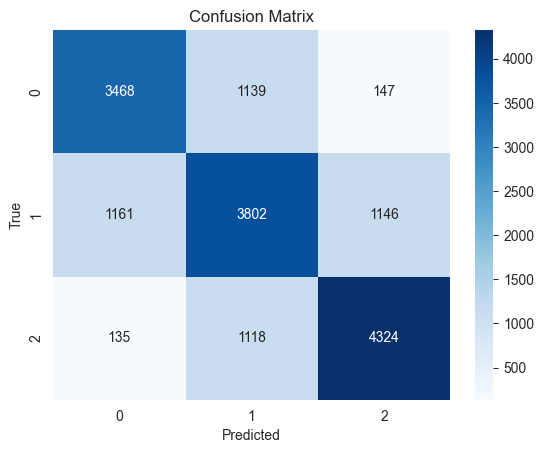

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4754
           1       0.63      0.62      0.62      6109
           2       0.77      0.78      0.77      5577

    accuracy                           0.71     16440
   macro avg       0.71      0.71      0.71     16440
weighted avg       0.70      0.71      0.71     16440

Overall Accuracy: 0.7052


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_pred, y_true, y_probs = evaluate_model(model_lstm, test_dataset, device)

## GRU

In [35]:
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

In [36]:
# Configuración del modelo
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 1
DROPOUT = 0.2
LR = 0.0001
EPOCHS = 60
# Inicializar modelo con GRU
model_gru = SentimentGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# Configurar optimizador y función de pérdida
optimizer = optim.Adam(model_gru.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_gru.to(device)

SentimentGRU(
  (embedding): Embedding(15941, 300, padding_idx=0)
  (rnn): GRU(300, 256, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

100%|█████████▉| 61675/61680 [24:48<00:00, 56.73it/s]

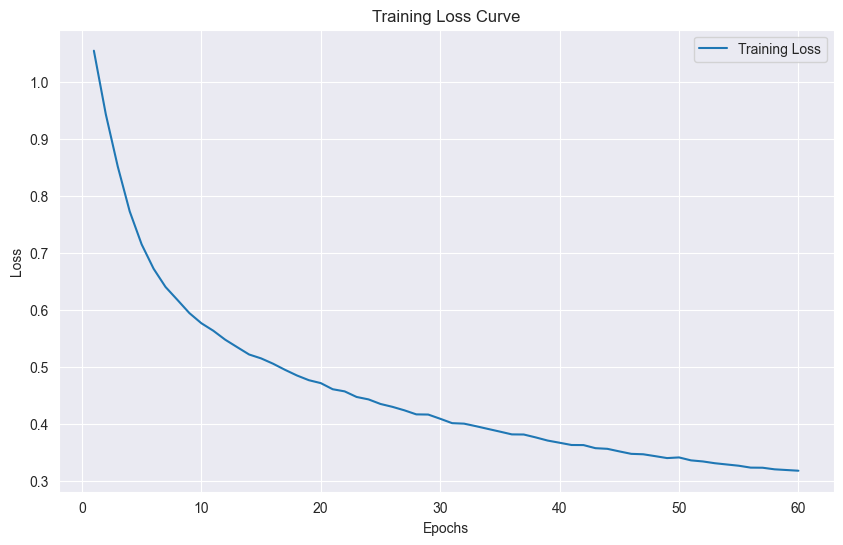

In [37]:
train_losses = []

# Barra de progreso para las épocas
progress_bar = tqdm(range(EPOCHS * len(train_loader)))

# Entrenamiento
for epoch in range(EPOCHS):
    model_gru.train()
    epoch_loss = 0

    for batch in train_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_gru(text)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.update()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

# Visualizar la curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()



Predicting: 100%|██████████| 257/257 [00:02<00:00, 101.12it/s]


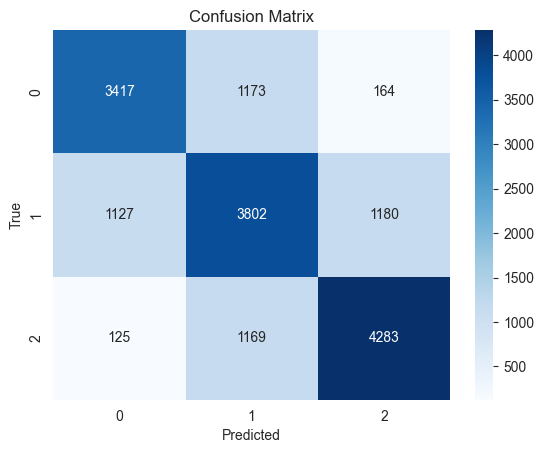

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      4754
           1       0.62      0.62      0.62      6109
           2       0.76      0.77      0.76      5577

    accuracy                           0.70     16440
   macro avg       0.70      0.70      0.70     16440
weighted avg       0.70      0.70      0.70     16440

Overall Accuracy: 0.6996


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_pred, y_true, y_probs = evaluate_model(model_gru, test_dataset, device)